In [ ]:

import random
import numpy as np
from copy import deepcopy
from sklearn.linear_model import LinearRegression

class EVOLUTIONARY_ANFIS:
  def __init__(self,functions,generations,offsprings,mutationRate,learningRate,chance,ruleComb):
    self.functions = functions
    self.generations = generations
    self.offsprings = offsprings
    self.mutationRate = mutationRate
    self.learningRate = learningRate
    self.chance = chance #50 percent chance of changing std.
    self.ruleComb = ruleComb
    self._noParam = 2

  def gaussian(self,x, mu, sig):
    return np.exp((-np.power(x - mu, 2.) / (2 * np.power(sig, 2.))))
    
  def initialize(self,X):
    functions = self.functions
    noParam = self._noParam
    ruleComb = self.ruleComb
    inputs = np.zeros((X.shape[1],X.shape[0],functions))
    Ant = np.zeros((noParam,X.shape[1],X.shape[0],functions))
    L1 = np.zeros((X.shape[1],X.shape[0],functions))
    if ruleComb == "simple":
      L2 = np.zeros((X.shape[0],functions)) 
    elif ruleComb == "complete":
      rules = X.shape[1]**functions
      L2 = np.zeros((X.shape[0],rules))   
    return inputs, Ant, L1, L2
    
  def mutation(self,arr):
     mutationRate = self.mutationRate
     learningRate = self.learningRate
     chance = self.chance
     temp = np.asarray(arr)   # Cast to numpy array
     mean = temp[0]
     meanShape = mean.shape
     std = temp[1]
     stdShape = std.shape
     mean = mean.flatten()    # Flatten to 1D
     std = std.flatten()    # Flatten to 1D
     num = int(mutationRate*mean.size) # number of elements to get
     if random.uniform(0,1)>chance:
         inds = np.random.choice(mean.size, size=num)   # Get random indices
         mean[inds] -= np.random.uniform(0,1,size=num)*learningRate        # Fill with something
         mean = mean.reshape(meanShape)                     # Restore original shape
         std = std.reshape(stdShape)
     else:
      inds = np.random.choice(std.size, size=num)   # Get random indices
      std[inds] -= np.random.uniform(0,1,size=num)*learningRate        # Fill with something
      std = std.reshape(stdShape)                     # Restore original shape    
      std = np.where(std==0, 0.0001, std) #standard deviation cannot be zero
      #temp = np.where(temp<=0, 0.0001, temp)
      #temp = np.where(temp>=1, 0.9999, temp)
           
      mean = mean.reshape(meanShape)
    #temp[0] = mean
    #temp[1] = std
    #return temp   
        
        
  def init_population(self,X):
    noParam = self._noParam
    functions = self.functions
    offsprings = self.offsprings
    bestParam = np.random.rand(noParam,X.shape[1],functions)
    parentParam = deepcopy(bestParam)
    popParam = []
    for i in range(offsprings):
      popParam.append(self.mutation(parentParam))
    return popParam
    
  def init_model(self,model=LinearRegression()):
    models = []
    for i in range(self.functions):
      models.append(model)
    return models

  def forwardPass(self,param,X,inputs,Ant,L1,L2,functions):
    noParam = self._noParam
        
    for i in range(X.shape[1]):   #input variables     
      inputs[i] = np.repeat(X[:,i].reshape(-1,1),functions,axis=1)

    for ii in range(noParam):   #Anticedent parameters
       for i in range(X.shape[1]):
          Ant[ii] = np.repeat(param[ii][i,:].reshape(1,-1),X.shape[0],axis=0)
        
    for i in range(X.shape[1]):  #Membership values using Gaussian membership function      
     L1[i,:,:] = self.gaussian(x=inputs[i],mu=Ant[0][i],sig=Ant[1][i])
      
    for j in range(functions):      #rule
      for i in range(1,X.shape[1]):
        L2[:,j] = (L1[i-1,:,j]*L1[i,:,j])#+(L1[i-1,:,j]+L1[i,:,j])
    
    summ = np.sum(L2,axis=1).reshape(-1,1) #Weights normalization
    summation = np.repeat(summ,functions,axis=1)
    L3 = L2/summation
    L3 = np.round(L3,5)
    #Errorcheck = np.sum(L3,axis=1)
    
    consequent = X
    L4 = np.zeros((functions,X.shape[0],X.shape[1]))
    for i in range (functions):
      L4[i] = consequent
      L4[i] = L4[i]*L3[:,i].reshape(-1,1)
    return L1,L2,L3,L4
    
  def linear_fit(self,L3,L4,X,y,functions,models):
    pred_train = np.zeros((X.shape[0],functions))
    for i in range(functions):
      models[i].fit(L4[i],y)
      predTemp = models[i].predict(L4[i])
      pred_train[:,i] = predTemp[:,0]       
    pred_train = pred_train*L3 #consequent function output * normalized weights
    pred_train = np.sum(pred_train,axis=1)
    return pred_train, models 

  def linear_predict(self,L3,L4,X,functions,Trained_models):
    pred_test = np.zeros((X.shape[0],functions))
    for i in range(functions):            
      predTemp = Trained_models[i].predict(L4[i]).reshape(-1,1)               
      pred_test[:,i] = predTemp[:,0]
    pred_test = pred_test*L3 #consequent function output * normalized weights
    pred_test = np.sum(pred_test,axis=1)
    return pred_test

    @staticmethod
  def rmse(true, pred):
    loss = np.sqrt(np.mean((true - pred)**2))
    return loss

  def fit(self,X_train,y_train,X_test=None,y_test=None,optimize_test_data=False):
    generations = self.generations
    offsprings = self.offsprings
    functions = self.functions
    popParam = self.init_population(X_train)
    inputsTrain,AntTrain,L1Train,L2Train = self.initialize(X_train)
    if optimize_test_data:
      inputsTest,AntTest,L1Test,L2Test = self.initialize(X_test)
    models = self.init_model()
    bestParam = popParam[0]
    for gen in range(generations):
      parentParam = deepcopy(bestParam)
      popParam[0] = deepcopy(bestParam)
      for ii in range(1,offsprings):
        mut = self.mutation(parentParam)        
        popParam[ii] = deepcopy(mut)
                    
      PopulationError = []
      bestModelLst = []
      for i in range(len(popParam)):
        L1,L2,L3,L4 = self.forwardPass(popParam[i],X_train,inputsTrain,AntTrain,L1Train,L2Train,functions)
        pred_train, Trained_models = self.linear_fit(L3,L4,X_train,y_train,functions,models)
        mse_train = self.rmse(y_train,pred_train)

        if optimize_test_data:
          L1,L2,L3,L4 = self.forwardPass(popParam[i],X_test,inputsTest,AntTest,L1Test,L2Test,functions)
          pred_test = self.linear_predict(L3,L4,X_test,functions,Trained_models)
          mse_test = self.rmse(y_test,pred_test)
                    
          PopulationError.append((mse_train+mse_test)/2)
          bestModelLst.append(Trained_models)
        else:
          PopulationError.append(mse_train)
          bestModelLst.append(Trained_models)

      bestParamIndex = np.argmin(PopulationError)
      bestParam = deepcopy(popParam[bestParamIndex])
      bestModel = bestModelLst[bestParamIndex]
      print(gen,"RMSE is: ",PopulationError[bestParamIndex])   
    return bestParam, bestModel

  def predict(self,X,bestParam,bestModel):
    functions = self.functions
    inputs,Ant,L1,L2 = self.initialize(X)
    L1,L2,L3,L4 = self.forwardPass(bestParam,X,inputs,Ant,L1,L2,functions)
    pred = self.linear_predict(L3,L4,X,functions,bestModel)
    return pred

IndentationError: ignored

ModuleNotFoundError: ignored

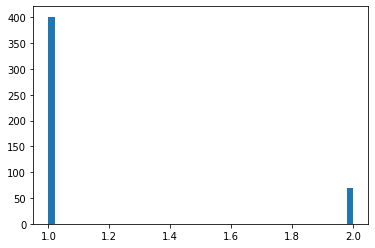

In [ ]:

from sklearn.model_selection import train_test_split 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler

data = pd.read_excel('walkertrain.xlsx')
test = pd.read_excel('walkertest.xlsx')

Data = data.loc[:,['x','y','v']]
test = test.loc[:,['x','y','v']]

#Data = data.loc[:,['FC','VM','Ash','Moisture','Cal V']]

# digitizing continuous variable
aa = Data['v']
minima = aa.min()
maxima = aa.max()
bins = np.linspace(minima-1,maxima+1, 3)
binned = np.digitize(aa, bins)
plt.hist(binned, bins=50)
data_train, data_test = train_test_split(Data, test_size=0.2,
                                          random_state=101,stratify=binned)

X_train = data_train.drop("v",axis=1).values
y_train = data_train["v"].copy().values
X_test = data_test.drop("v",axis=1).values
y_test = data_test["v"].copy().values
X_val = test.drop("v",axis=1).values
y_val = test["v"].copy().values

scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
scaler_x.fit(X_train)
X_train = scaler_x.transform(X_train)
X_test = scaler_x.transform(X_test)
#X_val = scaler_x.transform(X_val)
scaler_y.fit(y_train.reshape(-1,1))
y_train = scaler_y.transform(y_train.reshape(-1,1))
y_test = scaler_y.transform(y_test.reshape(-1,1))
#y_val = scaler_y.transform(y_val.reshape(-1,1))


from ANFIS import EVOLUTIONARY_ANFIS

E_Anfis = EVOLUTIONARY_ANFIS(functions=3,generations=500,offsprings=10,
                             mutationRate=0.2,learningRate=0.2,chance=0.7,ruleComb="simple")

bestParam, bestModel = E_Anfis.fit(X_train,y_train,optimize_test_data=False)

bestParam, bestModel = E_Anfis.fit(X_train,y_train,X_test,y_test,optimize_test_data=True)

from scipy.stats import pearsonr
pred_train = E_Anfis.predict(X_train,bestParam,bestModel)
pearsonr(y_train,pred_train.reshape(-1,1))

pred_test = E_Anfis.predict(X_test,bestParam,bestModel)
pearsonr(y_test,pred_test.reshape(-1,1))
        